In [1]:
import sys
sys.path.append("/users/jmduchar/data/jmduchar/Research/mcgill25/rfi_characterization/")
import python.utils as ut

import os
import numpy as np
from numpy.polynomial.legendre import legvander
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
import json
import glob
from scipy.stats import norm, cauchy, mode, t
import seaborn as sns
from tqdm import tqdm
import corner
import json

plt.style.use('seaborn-v0_8')

In [2]:
def map_to_unit_interval(u, umin=None, umax=None):
    u = np.asarray(u, dtype=np.float64)
    if umin is None: umin = float(np.min(u))
    if umax is None: umax = float(np.max(u))
    x = 2.0 * (u - umin) / (umax - umin) - 1.0
    return x, umin, umax

def legendre_design_numpy(u, L, umin=None, umax=None):
    x, umin, umax = map_to_unit_interval(u, umin, umax)
    A_full = legvander(x, L - 1)     # shape (T, L) -> columns: P_0 ... P_{L-1}
    return A_full.astype(np.float64, copy=False)

In [3]:
ABS_DIR = '/users/jmduchar/data/jmduchar/Research/mcgill25/rfi_characterization/'
STAN_FILE = ABS_DIR+'stan/legendre.stan'
DATAPATH = ABS_DIR+"data_private/raw_data/"
ANNOTATIONPATH = ABS_DIR+"data_private/annotations/"
ALL_FILES = glob.glob(DATAPATH+"*.npy")
ALL_ANNOTATIONS = glob.glob(ANNOTATIONPATH+"*.npy")

In [4]:
def build_legendre_design_matrix(y, L=8):
    u = np.arange(len(y), dtype=np.float64)
    A = legendre_design_numpy(u, L)
    
    return A

In [5]:
pointing = 'p0'

all_p = [i for i in ALL_FILES if pointing in i and "bad" not in i]
all_annotations = [i for i in ALL_ANNOTATIONS if pointing in i and "bad" not in i]

# print(len(all_p), len(all_annotations))

all_night_pointing = [(i.split("/")[-1].split("_")[2], i.split("/")[-1].split("_")[3].split(".")[0]) \
                      for i in all_p]
ann_night_pointing = [(i.split("/")[-1].split("_")[2], i.split("/")[-1].split("_")[3].split(".")[0]) \
                      for i in all_annotations]

all_A_unsup, all_A_sup = [], []
y_unsup, y_sup = [], []
s_sup = []
start_stop_unsup, start_stop_sup = [], []
obs_pointing = []

In [6]:
c_unsup = 0
c_sup = 0
L = 8

for pdx, (obs,p) in enumerate(all_night_pointing):
    sample = np.load(all_p[pdx])                         # (T_m,)
    A = build_legendre_design_matrix(sample, L)          # (T_m, L)
    
    if (obs,p) not in ann_night_pointing:  # UNSUP NIGHT
        y_unsup.extend(sample)
        all_A_unsup.extend(A)
        a = c_unsup
        b = c_unsup + len(sample) - 1
        start_stop_unsup.append((a, b))
        c_unsup += len(sample)
        
#     else:  # SUP NIGHT
#         y_sup.extend(sample)
#         all_A_sup.extend(A)
        
#         # Find the corresponding annotations
#         for annotation in all_annotations:
#             if obs in annotation and p in annotation:
#                 labels = np.load(annotation).astype(int)
#             break
            
#         assert len(labels) == len(sample)
#         s_sup.extend(labels)
#         a = c_sup
#         b = c_sup + len(sample) - 1
#         start_stop_sup.append((a, b))
#         c_sup += len(sample)
        
start_idx_unsup = [a+1 for (a,b) in start_stop_unsup]
stop_idx_unsup  = [b+1 for (a,b) in start_stop_unsup]
start_idx_sup   = [a+1 for (a,b) in start_stop_sup]
stop_idx_sup    = [b+1 for (a,b) in start_stop_sup]

In [7]:
type(L), type(y_unsup[0]), type(all_A_unsup[0]), type(start_idx_unsup[0])

(int, numpy.float64, numpy.ndarray, int)

In [8]:
data_dict = {
    'L':               L,
    
    'N_unsup':         int(len(y_unsup)),
    'y_unsup':         y_unsup,
    'A_unsup':         all_A_unsup,
    'M_unsup':         int(len(start_idx_unsup)),
    'start_idx_unsup': start_idx_unsup,
    'stop_idx_unsup':  stop_idx_unsup,
    
    'N_sup':           int(len(y_sup)),
    'y_sup':           y_sup,
    'A_sup':           all_A_sup,
    's_sup':           s_sup,
    'M_sup':           int(len(start_idx_sup)),
    'start_idx_sup':   start_idx_sup,
    'stop_idx_sup':    stop_idx_sup,
    
    'sigma':           0.33,
}

In [9]:
data_dict['N_sup']

0

In [10]:
# Save data to .json

# with open(
#     f"/users/jmduchar/data/jmduchar/Research/mcgill25/rfi_characterization/data/json/legendre_semisupervised_{pointing}.json",
#     "w"
# ) as f:
#     json.dump(data_dict, f, indent=2)

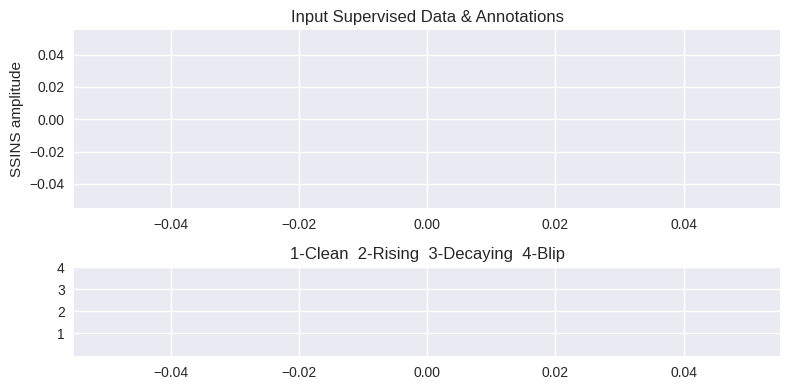

In [11]:
ut.plot_supervised_inputs(data_dict)

In [12]:
# # data_file = "../data/three_state.data.json"

model = CmdStanModel(stan_file=STAN_FILE)

# fit the model
fit = model.sample(
    data=data_dict,
    chains=4, parallel_chains=4,
    adapt_delta=0.995,          # tighter acceptance, fewer big jumps
    max_treedepth=15,           # allow longer trajectories
    show_console=True,
    output_dir="/users/jmduchar/data/jmduchar/Research/mcgill25/rfi_characterization/stan/stan_out/"
)

20:26:44 - cmdstanpy - INFO - compiling stan file /oscar/data/jpober/jmduchar/Research/mcgill25/rfi_characterization/stan/legendre.stan to exe file /oscar/data/jpober/jmduchar/Research/mcgill25/rfi_characterization/stan/legendre
20:27:21 - cmdstanpy - INFO - compiled model executable: /oscar/data/jpober/jmduchar/Research/mcgill25/rfi_characterization/stan/legendre
20:27:22 - cmdstanpy - INFO - Chain [1] start processing
20:27:22 - cmdstanpy - INFO - Chain [2] start processing
20:27:22 - cmdstanpy - INFO - Chain [3] start processing
20:27:22 - cmdstanpy - INFO - Chain [4] start processing
20:27:22 - cmdstanpy - INFO - Chain [1] done processing
20:27:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
20:27:22 - cmdstanpy - INFO - Chain [2] done processing
20:27:22 - cmdstanpy - ERROR - Chain [2] error: error during processing Operation not permitted
20:27:22 - cmdstanpy - INFO - Chain [3] done processing
20:27:22 - cmdstanpy - ERROR - Chain [3] erro

Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 1000 (Default)
Chain [1] num_warmup = 1000 (Default)
Chain [1] save_warmup = false (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = true (Default)
Chain [1] gamma = 0.05 (Default)
Chain [1] delta = 0.995
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] save_metric = false (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 15
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /tmp/tmpk_1bd6yh/ou0bfybc.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] seed = 54399
Chain [1] output
Chain [

RuntimeError: Error during sampling:
Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
	Exception: Exception: normal_lpdf: Random variable is nan, but must be not nan! (in 'legendre.stan', line 15, column 6 to column 43) (in 'legendre.stan', line 165, column 4 to line 168, column 56)
Command and output files:
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/oscar/data/jpober/jmduchar/Research/mcgill25/rfi_characterization/stan/legendre', 'id=1', 'random', 'seed=54399', 'data', 'file=/tmp/tmpk_1bd6yh/ou0bfybc.json', 'output', 'file=/oscar/data/jpober/jmduchar/Research/mcgill25/rfi_characterization/stan/stan_out/legendre-20251020202722_1.csv', 'method=sample', 'algorithm=hmc', 'engine=nuts', 'max_depth=15', 'adapt', 'engaged=1', 'delta=0.995']
 retcodes=[1, 1, 1, 1]
 per-chain output files (showing chain 1 only):
 csv_file:
	/oscar/data/jpober/jmduchar/Research/mcgill25/rfi_characterization/stan/stan_out/legendre-20251020202722_1.csv
 console_msgs (if any):
	/oscar/data/jpober/jmduchar/Research/mcgill25/rfi_characterization/stan/stan_out/legendre-20251020202722_0-stdout.txt

In [9]:
print(fit.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



In [10]:
len(data_dict['y_unsup']), fit.stan_variable('viterbi').shape

(21765, (4000, 21765))

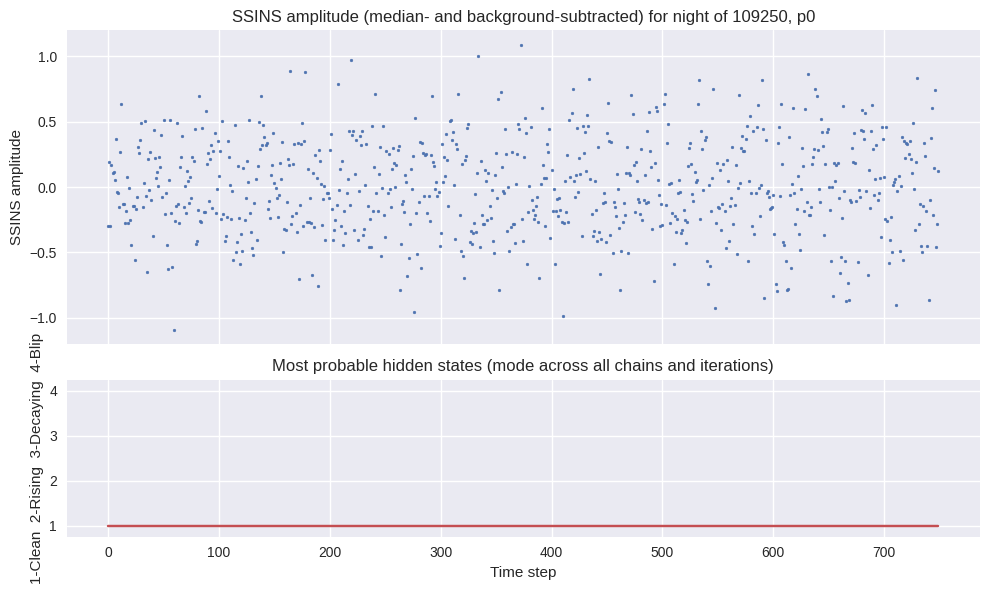

In [12]:
# for i in range(len(obs_pointing)):
ut.plot_data_vs_pred(data_dict['y_unsup'], fit, 'p0', cut_idx=0)

In [13]:
viterbi = fit.stan_variable('viterbi')

viterbi.shape

(4000, 21765)

In [14]:
fit.draws().shape

(1000, 4, 51511)

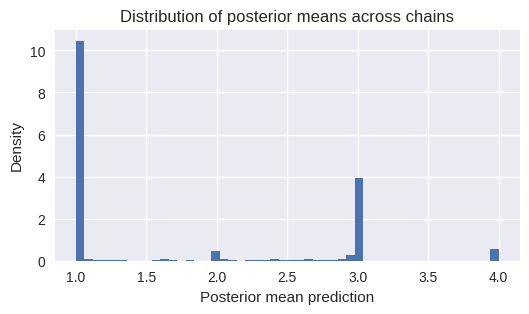

In [15]:
plt.figure(figsize=(6,3))
means = viterbi.mean(axis=0)  # mean over draws for each of 21765 samples
plt.hist(means, bins=50, density=True)
plt.xlabel("Posterior mean prediction")
plt.ylabel("Density")
plt.title("Distribution of posterior means across chains")
plt.savefig("../figures/postprocessing/posterior_mean_dist.png",dpi=300,bbox_inches='tight')
plt.show()

In [16]:
fit.stan_variables()

{'theta_clean': array([[0.981618  , 0.0172041 , 0.00117747],
        [0.98418   , 0.0138279 , 0.00199223],
        [0.982815  , 0.0157966 , 0.00138825],
        ...,
        [0.983115  , 0.0147467 , 0.00213846],
        [0.98476   , 0.0138623 , 0.00137745],
        [0.982927  , 0.0152469 , 0.00182597]], shape=(4000, 3)),
 'theta_rising': array([[0.864133  , 0.120439  , 0.0154278 ],
        [0.845849  , 0.144563  , 0.00958792],
        [0.860702  , 0.128956  , 0.0103421 ],
        ...,
        [0.859619  , 0.126671  , 0.0137104 ],
        [0.849172  , 0.135141  , 0.0156874 ],
        [0.868843  , 0.116592  , 0.0145648 ]], shape=(4000, 3)),
 'theta_decay': array([[0.0591816, 0.0125763, 0.917035 , 0.0112075],
        [0.0564281, 0.0141187, 0.912419 , 0.0170344],
        [0.0554899, 0.0138886, 0.91924  , 0.0113819],
        ...,
        [0.0519877, 0.0101281, 0.92362  , 0.0142645],
        [0.054121 , 0.0150471, 0.917206 , 0.0136254],
        [0.0542277, 0.0101248, 0.922207 , 0.0134406]], 

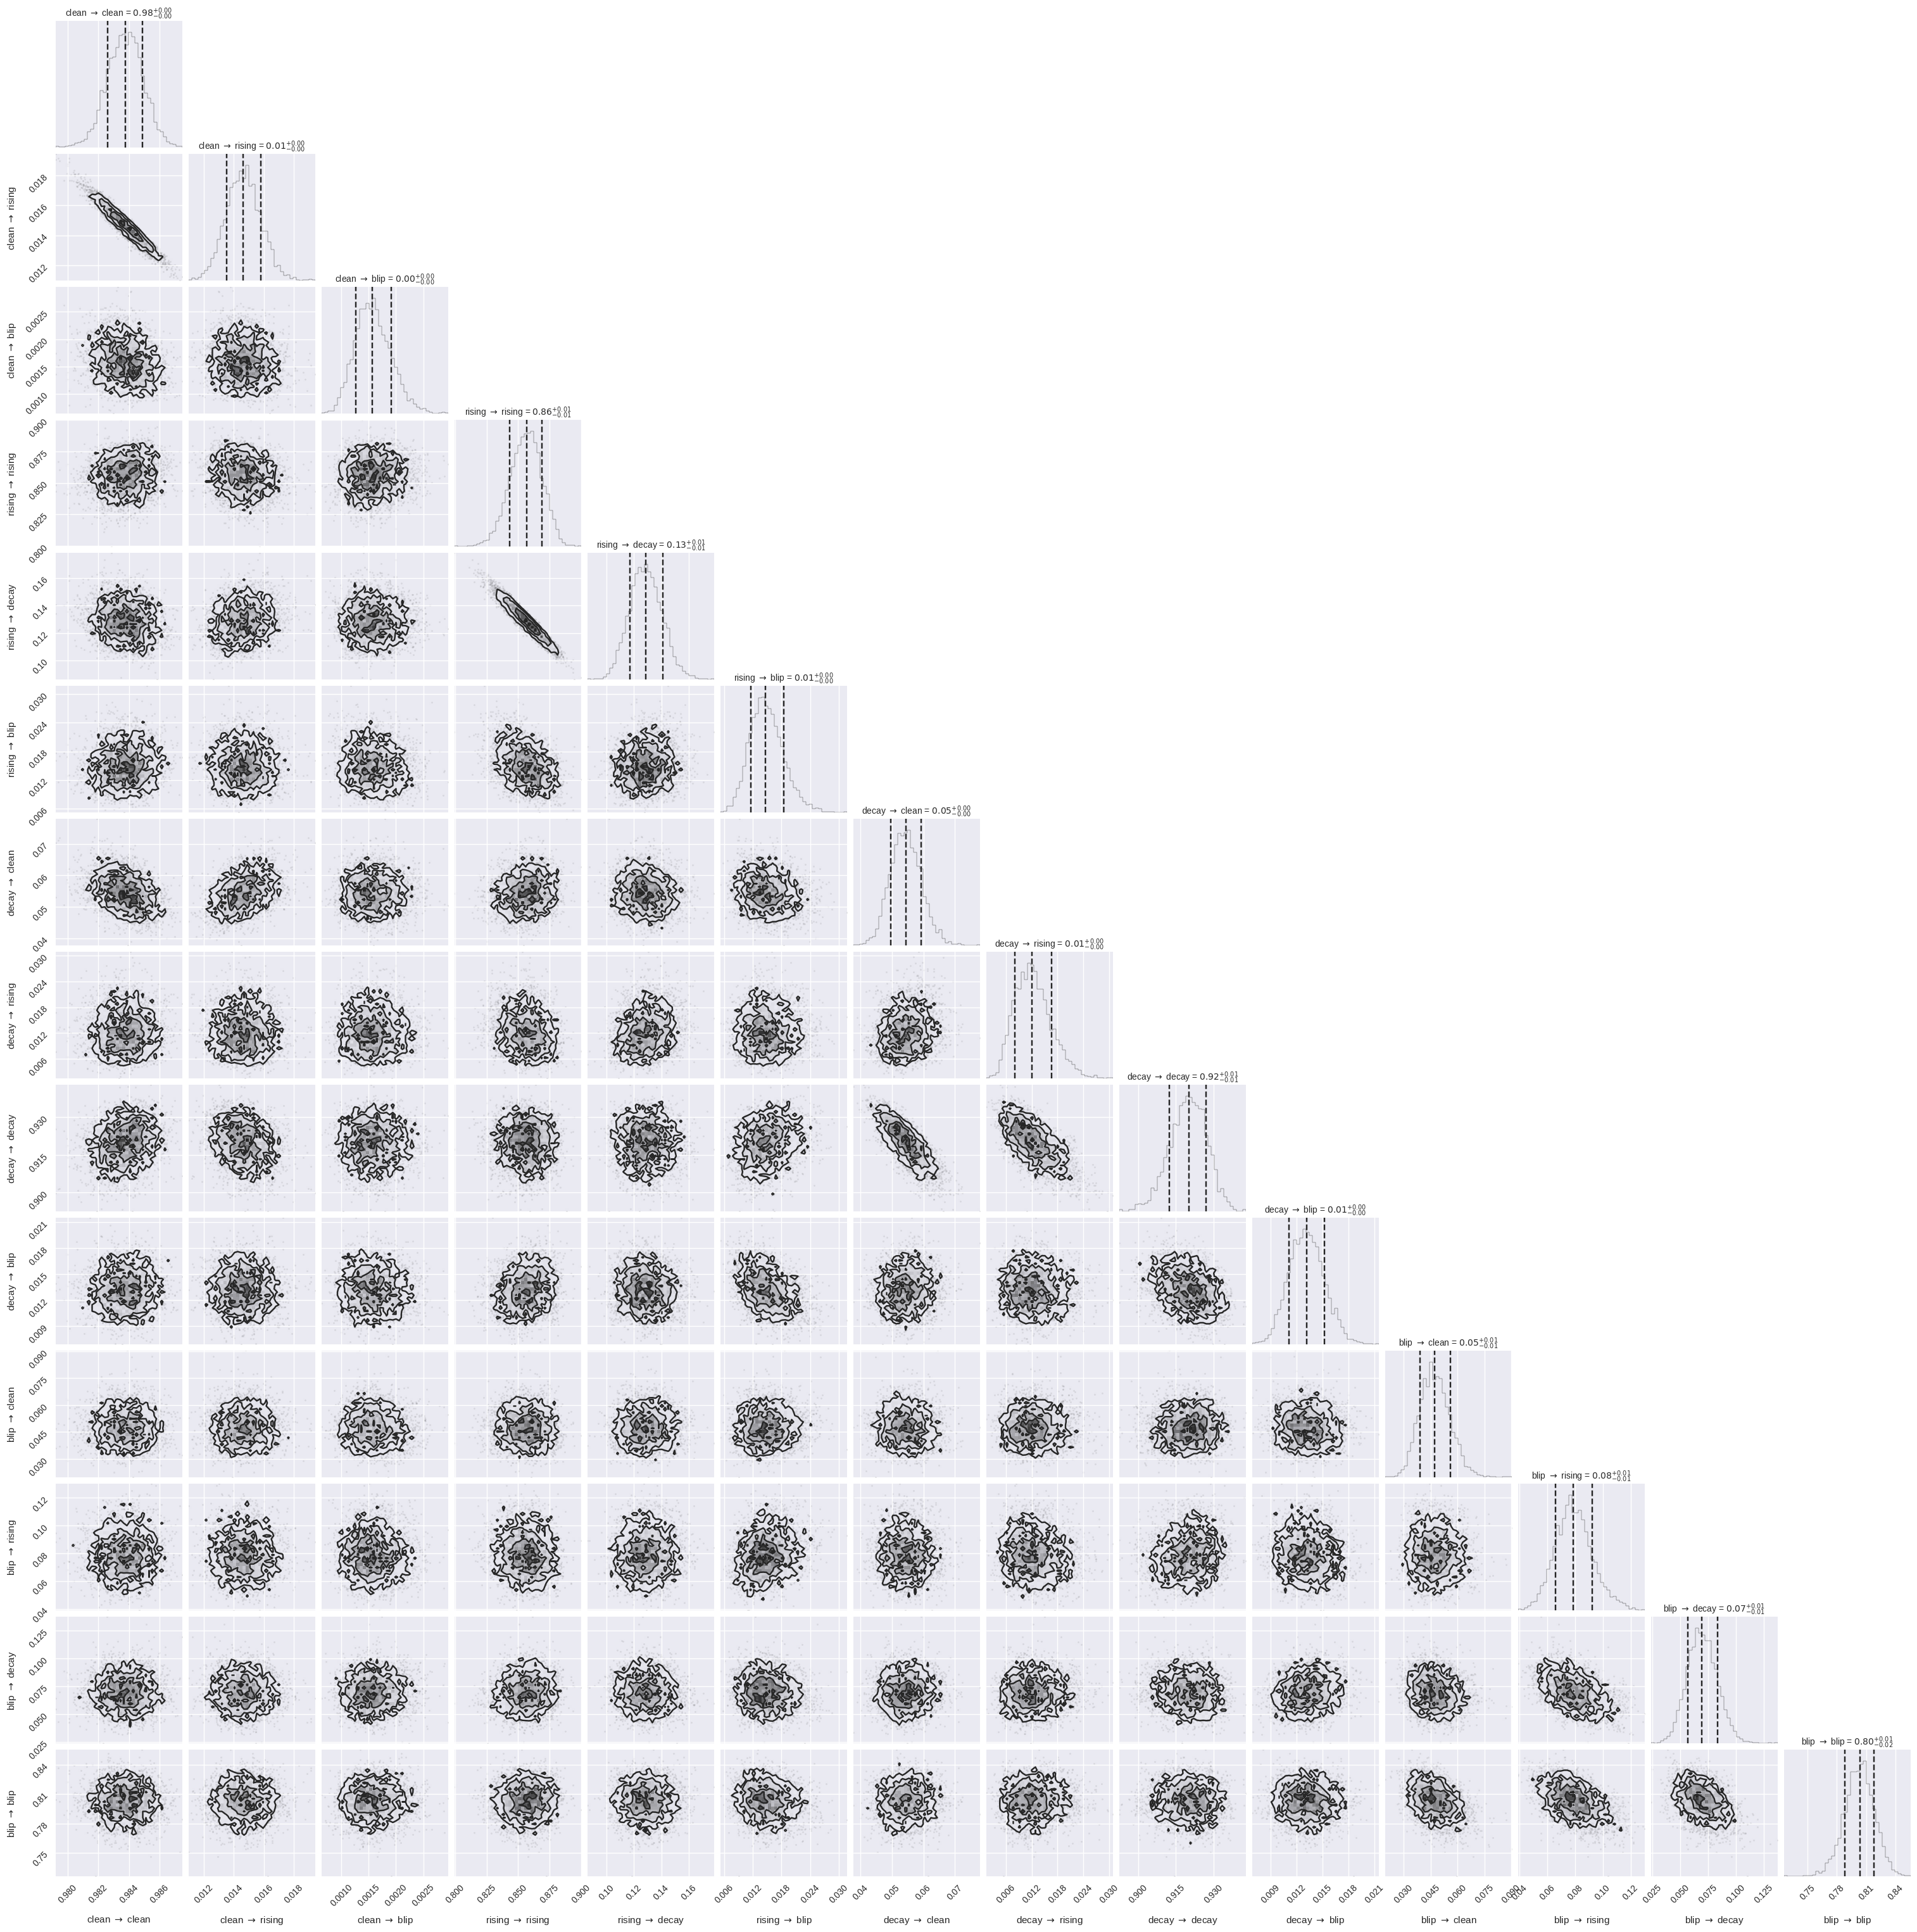

In [17]:
ut.transition_corner_plot(fit)

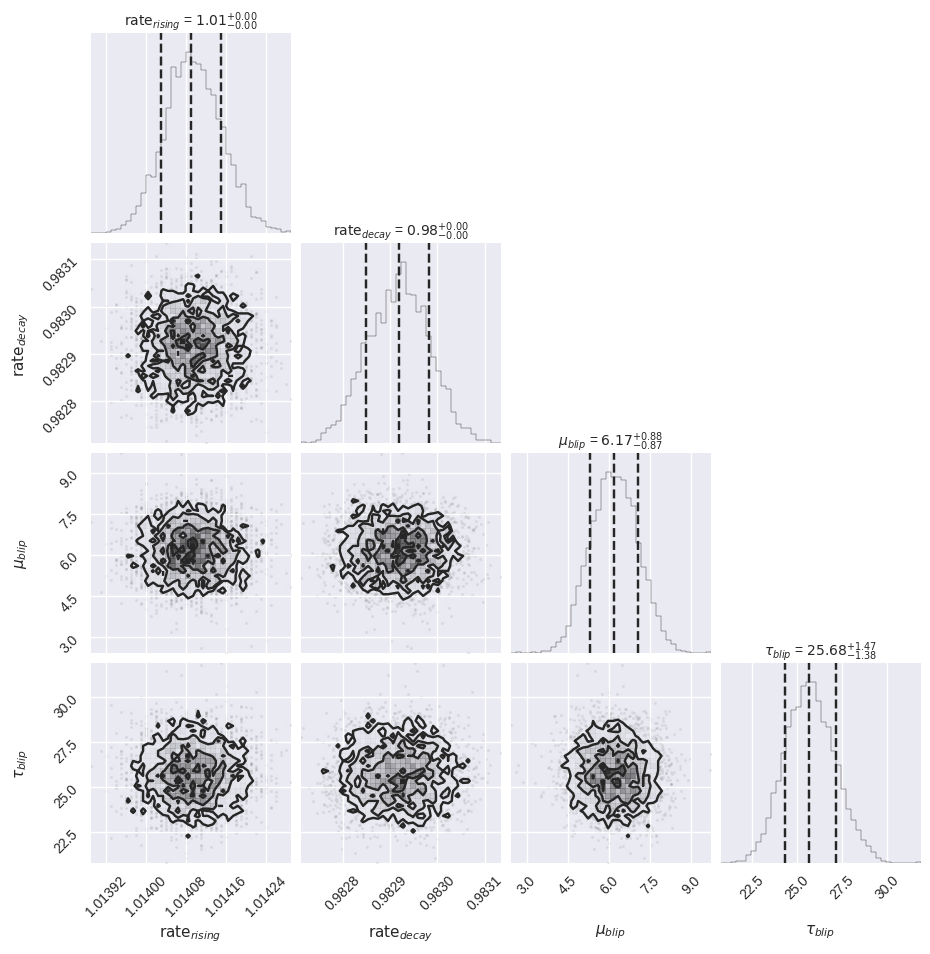

In [18]:
params = np.column_stack([
    fit.stan_variable("rate_rising"),
    fit.stan_variable("rate_decay"),
    fit.stan_variable("mu_blip"),
#     fit.stan_variable("sigma"),
    fit.stan_variable("tau_blip"),
])

labels = [
    r"$\mathrm{rate}_{rising}$",
    r"$\mathrm{rate}_{decay}$",
    r"$\mu_{blip}$",
#     r"$\sigma$",
    r"$\tau_{blip}$"
]

# Make corner plot
fig = corner.corner(
    params,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 10},
    bins=40
)
plt.savefig("../figures/postprocessing/emission_corner.png",dpi=300,bbox_inches='tight')
plt.show()

In [19]:
data = np.asarray(data_dict['y_unsup'])
viterbi = fit.stan_variable('viterbi')
predictions = mode(viterbi).mode

clean_mask = predictions == 1
rising_mask = predictions == 2
decay_mask = predictions == 3
blip_mask = predictions == 4

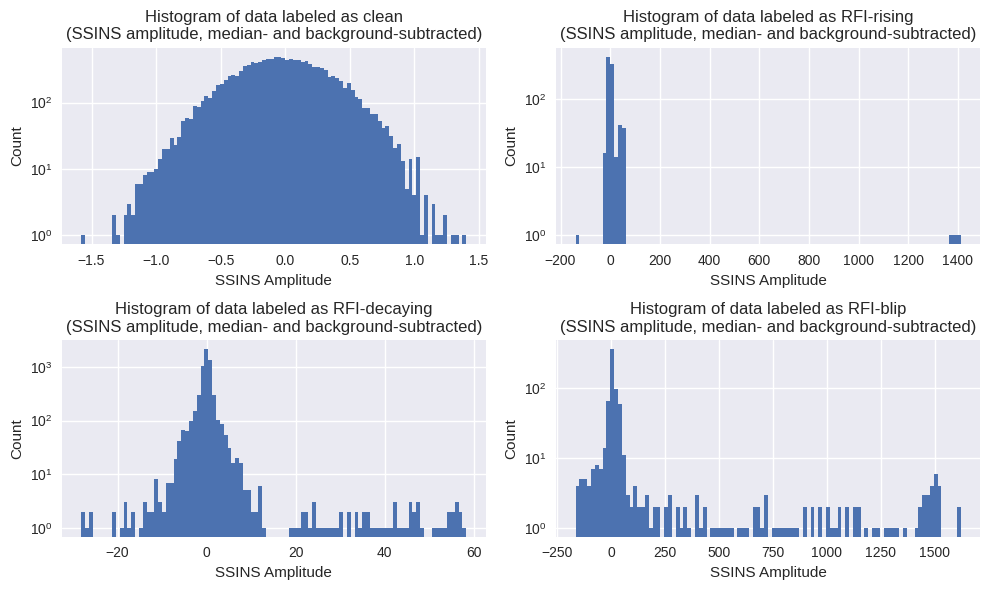

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs = axs.ravel()

# Clean
axs[0].hist(data[clean_mask], bins=100)
axs[0].set_title("Histogram of data labeled as clean\n(SSINS amplitude, median- and background-subtracted)")
axs[0].set_xlabel("SSINS Amplitude")
axs[0].set_ylabel("Count")
axs[0].set_yscale("log")

# Rising
axs[1].hist(data[rising_mask], bins=100)
axs[1].set_title("Histogram of data labeled as RFI-rising\n(SSINS amplitude, median- and background-subtracted)")
axs[1].set_xlabel("SSINS Amplitude")
axs[1].set_ylabel("Count")
axs[1].set_yscale("log")

# Decay
axs[2].hist(data[decay_mask], bins=100)
axs[2].set_title("Histogram of data labeled as RFI-decaying\n(SSINS amplitude, median- and background-subtracted)")
axs[2].set_xlabel("SSINS Amplitude")
axs[2].set_ylabel("Count")
axs[2].set_yscale("log")

# Blip
axs[3].hist(data[blip_mask], bins=100)
axs[3].set_title("Histogram of data labeled as RFI-blip\n(SSINS amplitude, median- and background-subtracted)")
axs[3].set_xlabel("SSINS Amplitude")
axs[3].set_ylabel("Count")
axs[3].set_yscale("log")

plt.tight_layout()
plt.savefig("../figures/postprocessing/label_hist_nooverlay.png",dpi=300,bbox_inches='tight')
plt.show()

<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_496521/2662924586.py:46: SyntaxWarning: invalid escape sequence '\s'
  lw=2, label=f"Empirical N(0, $\sigma$ = {empirical_std:.2f})",


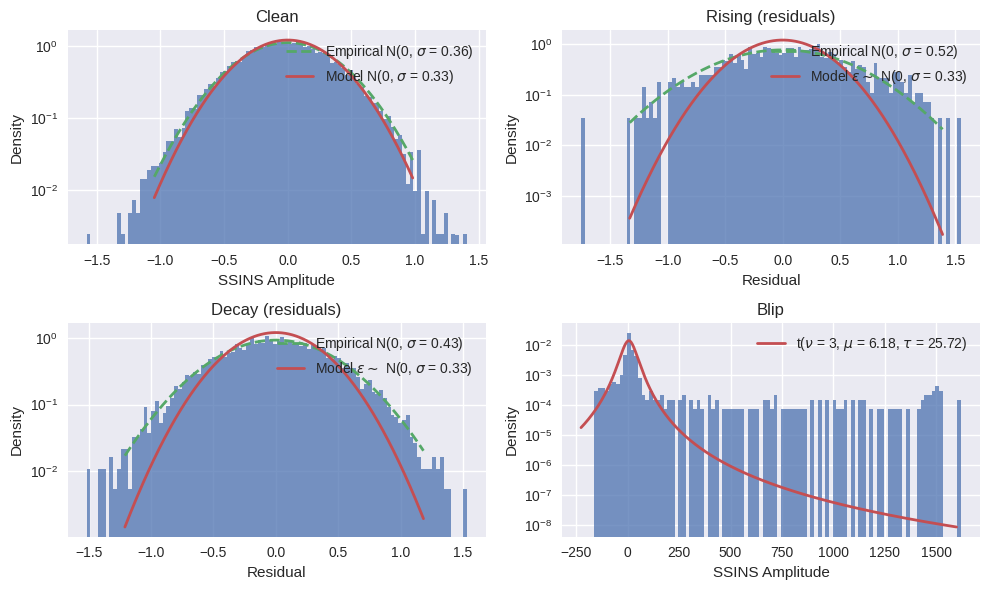

In [21]:
# sigma = float(np.mean(fit.stan_variable("sigma")))
sigma = 0.33
rate_rising = float(np.mean(fit.stan_variable("rate_rising")))
rate_decay  = float(np.mean(fit.stan_variable("rate_decay")))
mu_blip     = float(np.mean(fit.stan_variable("mu_blip")))
tau_blip    = float(np.mean(fit.stan_variable("tau_blip")))

# ---- data & states ----
y = np.asarray(data_dict['y_unsup'])
viterbi = fit.stan_variable('viterbi')
pred = mode(viterbi).mode

clean_mask = pred == 1
rising_mask = pred == 2
decay_mask  = pred == 3
blip_mask   = pred == 4

# shift y by one to get y_{t-1}
y_tm1 = np.roll(y, 1)      # rolls right, so y_tm1[t] = y[t-1]
y_tm1[0] = np.nan          # first element has no predecessor

# residuals only where states are rising/decay
r_resid = y[rising_mask] - rate_rising * y_tm1[rising_mask]
d_resid = y[decay_mask]  - rate_decay  * y_tm1[decay_mask]
r_resid = r_resid[~np.isnan(r_resid)]
d_resid = d_resid[~np.isnan(d_resid)]

clean_y = y[clean_mask]
blip_y  = y[blip_mask]

# ---- plotting helpers ----
def robust_range(arr, lo=0.5, hi=99.5, pad=0.05):
    if arr.size == 0:
        return (-1, 1)
    a, b = np.percentile(arr, [lo, hi])
    m = (b - a)
    return (a - pad*m, b + pad*m)

def overlay(ax, samples, pdf, title, label, bins='fd'):
    ax.hist(samples, bins=100, density=True, alpha=0.75)
    xmin, xmax = robust_range(samples)
    x = np.linspace(xmin, xmax, 600)
    if title!="Blip":
        empirical_std = np.std(samples, ddof=1)
        ax.plot(x, norm.pdf(x, loc=0.0, scale=empirical_std), 
                lw=2, label=f"Empirical N(0, $\sigma$ = {empirical_std:.2f})",
                linestyle='--', color=sns.color_palette()[1],
               )
    ax.plot(x, pdf(x), lw=2, label=label, color=sns.color_palette()[2])
    ax.set_title(title)
    ax.set_xlabel("SSINS Amplitude" if "residual" not in title.lower() else "Residual")
    ax.set_ylabel("Density")
    ax.set_yscale("log")
    ax.legend(loc="upper right", frameon=False)

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs = axs.ravel()

# Clean: y_t ~ N(0, sigma)
overlay(
    axs[0], clean_y,
    lambda x: norm.pdf(x, loc=0.0, scale=sigma),
    "Clean",
    fr"Model N(0, $\sigma$ = {sigma:.2f})"
)

# Rising: residuals y_t - rate_rising*y_{t-1} ~ N(0, sigma)
overlay(
    axs[1], r_resid,
    lambda x: norm.pdf(x, loc=0.0, scale=sigma),
    "Rising (residuals)",
    fr"Model $\epsilon \sim$ N(0, $\sigma$ = {sigma:.2f})"
)

# Decay: residuals y_t - rate_decay*y_{t-1} ~ N(0, sigma)
overlay(
    axs[2], d_resid,
    lambda x: norm.pdf(x, loc=0.0, scale=sigma),
    "Decay (residuals)",
    fr"Model $\epsilon \sim$ N(0, $\sigma$ = {sigma:.2f})"
)

# Blip: y_t ~ Student-t(ν=3, μ, τ)
overlay(
    axs[3], blip_y,
    lambda x: t.pdf(x, df=3, loc=mu_blip, scale=tau_blip),
    "Blip",
    fr"t($\nu$ = 3, $\mu$ = {mu_blip:.2f}, $\tau$ = {tau_blip:.2f})"
)

plt.tight_layout()
plt.savefig("../figures/postprocessing/label_hist_overlay.png",dpi=300,bbox_inches='tight')
plt.show()